# 젠더 법안 K-means

In [13]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
from krwordrank.hangle import normalize
%matplotlib inline

In [14]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [15]:
gender = pd.read_csv('./18th-gender-bill.csv', 
                      index_col=0, parse_dates=['제안일자','의결일자'] )
# gender = gender.drop('level_0',1)
print(gender.shape)

(820, 10)


In [16]:
gender.head()

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,1814762,청소년 가출예방 및 자립지원에 관한 법률안,2012-05-25,의원,2012-05-29,임기만료폐기,제18대 (2008~2012) 제307회,"빈곤, 부모의 이혼, 가정폭력, 학대, 방임 및 학교부적응 등 복합적인 원인에...",여성가족위원회,"['강명순', '권영진', '권택기', '김무성', '김성태', '김소남', '김용..."
1,1814751,저출산·고령사회기본법 일부개정법률안,2012-05-02,위원장,2012-05-02,원안가결,제18대 (2008~2012) 제307회,"위 9건의 법률안을 심사한 결과, 이들을 제304회 국회(임시회) 저출산고령화...",저출산고령화대책특별위원회,[]
2,1814743,모자보건법 일부개정법률안,2012-05-02,위원장,2012-05-02,원안가결,제18대 (2008~2012) 제307회,"위 2건의 법률안을 심사한 결과, 제304회 국회(임시회) 제1차 전체회의(2...",보건복지위원회,[]
3,1814699,유아교육법 일부개정법률안,2012-02-27,위원장,2012-02-27,원안가결,제18대 (2008~2012) 제306회,"■ 대안의 제안경위가. 2009월 7월 7일 원희목의원 등 12인, 2009년 ...",교육과학기술위원회,[]
4,1814659,보조생식에 관한 법률안,2012-02-10,의원,2012-05-29,임기만료폐기,제18대 (2008~2012) 제305회,■ 현재 난임으로 인한 보조생식 시술이 증가하고 있으나 보조생식에 관하여 「생...,보건복지위원회,"['이영애', '김정', '김혜성', '이두아', '이성남', '임영호', '정미경..."


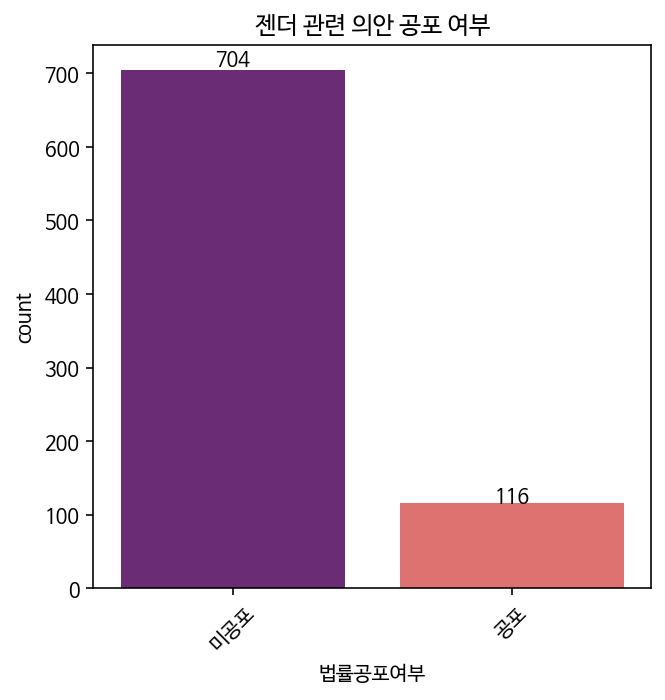

In [18]:
def proornot_vis(df, name): 
    # hue_order = ['공포','미공포']
    
    plt.figure(figsize = (5,5))
    plt.xticks(rotation = 45)
    ax = sns.countplot(x = '법률공포여부', data = df, 
              palette = 'magma', hue_order=['공포','미공포'])

    for p in ax.patches: 
        left, bottom, width, height = p.get_bbox().bounds 
        ax.annotate("%.1d"%(height), (left+width/2, height*1.01), ha='center')

    plt.title(f'{name} 관련 의안 공포 여부')
    plt.show()

proclaim_list = ['원안가결', '수정가결']
reject_list = ['임기만료폐기', '대안반영폐기', '철회', '폐기', '부결', '수정안반영폐기','계류']

gender.loc[gender['의결결과'].isin(proclaim_list), '법률공포여부'] = '공포'
gender.loc[gender['의결결과'].isin(reject_list), '법률공포여부'] = '미공포'

proornot_vis(gender, '젠더')

In [4]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [5]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [6]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 67.1 ms, sys: 2.96 ms, total: 70 ms
Wall time: 75.6 ms


In [7]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [8]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 50 s, sys: 958 ms, total: 50.9 s
Wall time: 39.2 s


0    [청소년, 가출예방, 자립지원, 법률안, 빈곤, 부모, 이혼, 가정폭력, 학대, 학...
1    [저출산, 고령사회기본법, 일부개정법률안, 법률안, 심사한, 결과, 국회, 임시회,...
2    [모자보건법, 일부개정법률안, 법률안, 심사한, 결과, 국회, 임시회, 전체회의, ...
Name: tokens, dtype: object

In [9]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 193 ms, sys: 3.21 ms, total: 196 ms
Wall time: 205 ms


In [10]:
%time gender['명사수'] = gender['tokens'].apply(len)

CPU times: user 1.45 ms, sys: 667 µs, total: 2.12 ms
Wall time: 1.6 ms


In [11]:
# 명사 수가 50개를 넘어가는 경우만 추출
gender = gender[gender['명사수'] >= 10]
gender = gender.reset_index(drop=True)
print(gender.shape)

(818, 13)


In [12]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [13]:
# 모델 생성

#포스태깅된 컨텐츠를 100차원의 벡터로 바꿔라. 주변 단어(window)는 앞뒤로 두개까지 보고, 코퍼스 내 출현 빈도가 10번 미만인 단어는 분석에서 제외해라.
#CPU는 쿼드코어를 쓰고 100번 반복 학습해라. 분석방법론은 CBOW와 Skip-Gram 중 후자를 선택해라.
model = Word2Vec(gender['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)

2020-09-27 00:42:28,160 : INFO : collecting all words and their counts
2020-09-27 00:42:28,162 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-27 00:42:28,184 : INFO : collected 10373 word types from a corpus of 85439 raw words and 818 sentences
2020-09-27 00:42:28,184 : INFO : Loading a fresh vocabulary
2020-09-27 00:42:28,194 : INFO : effective_min_count=10 retains 1451 unique words (13% of original 10373, drops 8922)
2020-09-27 00:42:28,194 : INFO : effective_min_count=10 leaves 64800 word corpus (75% of original 85439, drops 20639)
2020-09-27 00:42:28,202 : INFO : deleting the raw counts dictionary of 10373 items
2020-09-27 00:42:28,204 : INFO : sample=0.001 downsamples 62 most-common words
2020-09-27 00:42:28,206 : INFO : downsampling leaves estimated 56644 word corpus (87.4% of prior 64800)
2020-09-27 00:42:28,210 : INFO : estimated required memory for 1451 words and 100 dimensions: 1886300 bytes
2020-09-27 00:42:28,211 : INFO : resetting layer 

2020-09-27 00:42:29,384 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:42:29,390 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:42:29,392 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:42:29,393 : INFO : EPOCH - 15 : training on 85439 raw words (56663 effective words) took 0.0s, 1201243 effective words/s
2020-09-27 00:42:29,438 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:42:29,442 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:42:29,443 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:42:29,444 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:42:29,445 : INFO : EPOCH - 16 : training on 85439 raw words (56684 effective words) took 0.0s, 1188002 effective words/s
2020-09-27 00:42:29,490 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-09-27 00:42:30,262 : INFO : EPOCH - 31 : training on 85439 raw words (56607 effective words) took 0.1s, 981612 effective words/s
2020-09-27 00:42:30,311 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:42:30,312 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:42:30,314 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:42:30,318 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:42:30,319 : INFO : EPOCH - 32 : training on 85439 raw words (56643 effective words) took 0.1s, 1085614 effective words/s
2020-09-27 00:42:30,360 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:42:30,366 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:42:30,369 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:42:30,371 : INFO : worker thread finished; awaiting finish of 0 more threads
202

2020-09-27 00:42:31,355 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:42:31,359 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:42:31,362 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:42:31,363 : INFO : EPOCH - 48 : training on 85439 raw words (56734 effective words) took 0.1s, 1115135 effective words/s
2020-09-27 00:42:31,413 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:42:31,417 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:42:31,420 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:42:31,424 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:42:31,426 : INFO : EPOCH - 49 : training on 85439 raw words (56585 effective words) took 0.1s, 1029291 effective words/s
2020-09-27 00:42:31,472 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-09-27 00:42:32,422 : INFO : EPOCH - 64 : training on 85439 raw words (56666 effective words) took 0.1s, 795318 effective words/s
2020-09-27 00:42:32,491 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:42:32,493 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:42:32,495 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:42:32,497 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:42:32,498 : INFO : EPOCH - 65 : training on 85439 raw words (56592 effective words) took 0.1s, 831168 effective words/s
2020-09-27 00:42:32,554 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:42:32,560 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:42:32,562 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:42:32,565 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

2020-09-27 00:42:33,540 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:42:33,544 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:42:33,547 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:42:33,548 : INFO : EPOCH - 81 : training on 85439 raw words (56641 effective words) took 0.0s, 1140366 effective words/s
2020-09-27 00:42:33,595 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:42:33,598 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:42:33,600 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:42:33,602 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:42:33,602 : INFO : EPOCH - 82 : training on 85439 raw words (56679 effective words) took 0.1s, 1109799 effective words/s
2020-09-27 00:42:33,652 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-09-27 00:42:34,456 : INFO : EPOCH - 97 : training on 85439 raw words (56626 effective words) took 0.1s, 1045146 effective words/s
2020-09-27 00:42:34,514 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:42:34,518 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:42:34,520 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:42:34,521 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:42:34,522 : INFO : EPOCH - 98 : training on 85439 raw words (56692 effective words) took 0.1s, 910518 effective words/s
2020-09-27 00:42:34,566 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:42:34,567 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:42:34,571 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:42:34,575 : INFO : worker thread finished; awaiting finish of 0 more threads
202

In [14]:
# 문장 벡터 생성
def get_sentence_mean_vector(morphs):
    vector = []
    for i in morphs:
        try:
            vector.append(model.wv[i])
        except:
            pass
    try:
        return np.mean(vector, axis=0)
    except:
        pass
    
# 엘보우 함수
def elbow(X):
    sse = []
    for i in tqdm(range(1,15), desc = '엘보우'):
        km = KMeans(init='k-means++', n_clusters = i, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1,15), sse, marker='o')
    plt.xlabel("number of cluster")
    plt.ylabel("SSE")
    plt.show()

In [15]:
# 문장 벡터 생성
gender['문장벡터'] = gender['tokens'].map(get_sentence_mean_vector)

In [16]:
len(gender['문장벡터'][0])

100

In [17]:
print(model.wv.most_similar('여성'))
print(model.wv.most_similar('청소년'))

2020-09-27 00:42:34,836 : INFO : precomputing L2-norms of word weight vectors


[('여성들', 0.5128288865089417), ('사회활동', 0.40668559074401855), ('경제활동', 0.3856942057609558), ('남성', 0.3672093451023102), ('남성근로자', 0.3533433675765991), ('단절', 0.3496716320514679), ('유산', 0.345400869846344), ('보호휴가', 0.34450429677963257), ('참여', 0.33075112104415894), ('정치참여', 0.33004140853881836)]
[('아동', 0.6249579191207886), ('성범죄자', 0.5210738182067871), ('성범죄', 0.46905824542045593), ('취업제한', 0.40285664796829224), ('청소년대상', 0.4005507230758667), ('노무', 0.3975141644477844), ('성적', 0.3857744038105011), ('유죄판결', 0.3848692774772644), ('성보호', 0.3830263614654541), ('친권자', 0.3821970522403717)]


In [18]:
# model.wv.vocab.items()

## t-SNE 시각화

In [19]:
import time
from sklearn.manifold import TSNE

n_sne = 7000

wv_list = list(gender['문장벡터'])
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(wv_list)

tsne_df = pd.DataFrame(tsne_results, index=gender['의안명'], columns=["x", "y"])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 818 samples in 0.003s...
[t-SNE] Computed neighbors for 818 samples in 0.112s...
[t-SNE] Computed conditional probabilities for sample 818 / 818
[t-SNE] Mean sigma: 2.456426
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.361351
[t-SNE] KL divergence after 300 iterations: 0.946593


In [20]:
tsne_df.head()

,x,y
의안명,,
청소년 가출예방 및 자립지원에 관한 법률안,1.012923,-8.863115
저출산·고령사회기본법 일부개정법률안,-6.119627,-7.312590
모자보건법 일부개정법률안,-2.856864,2.377295
유아교육법 일부개정법률안,-2.852996,3.676884
보조생식에 관한 법률안,2.585103,-3.379926


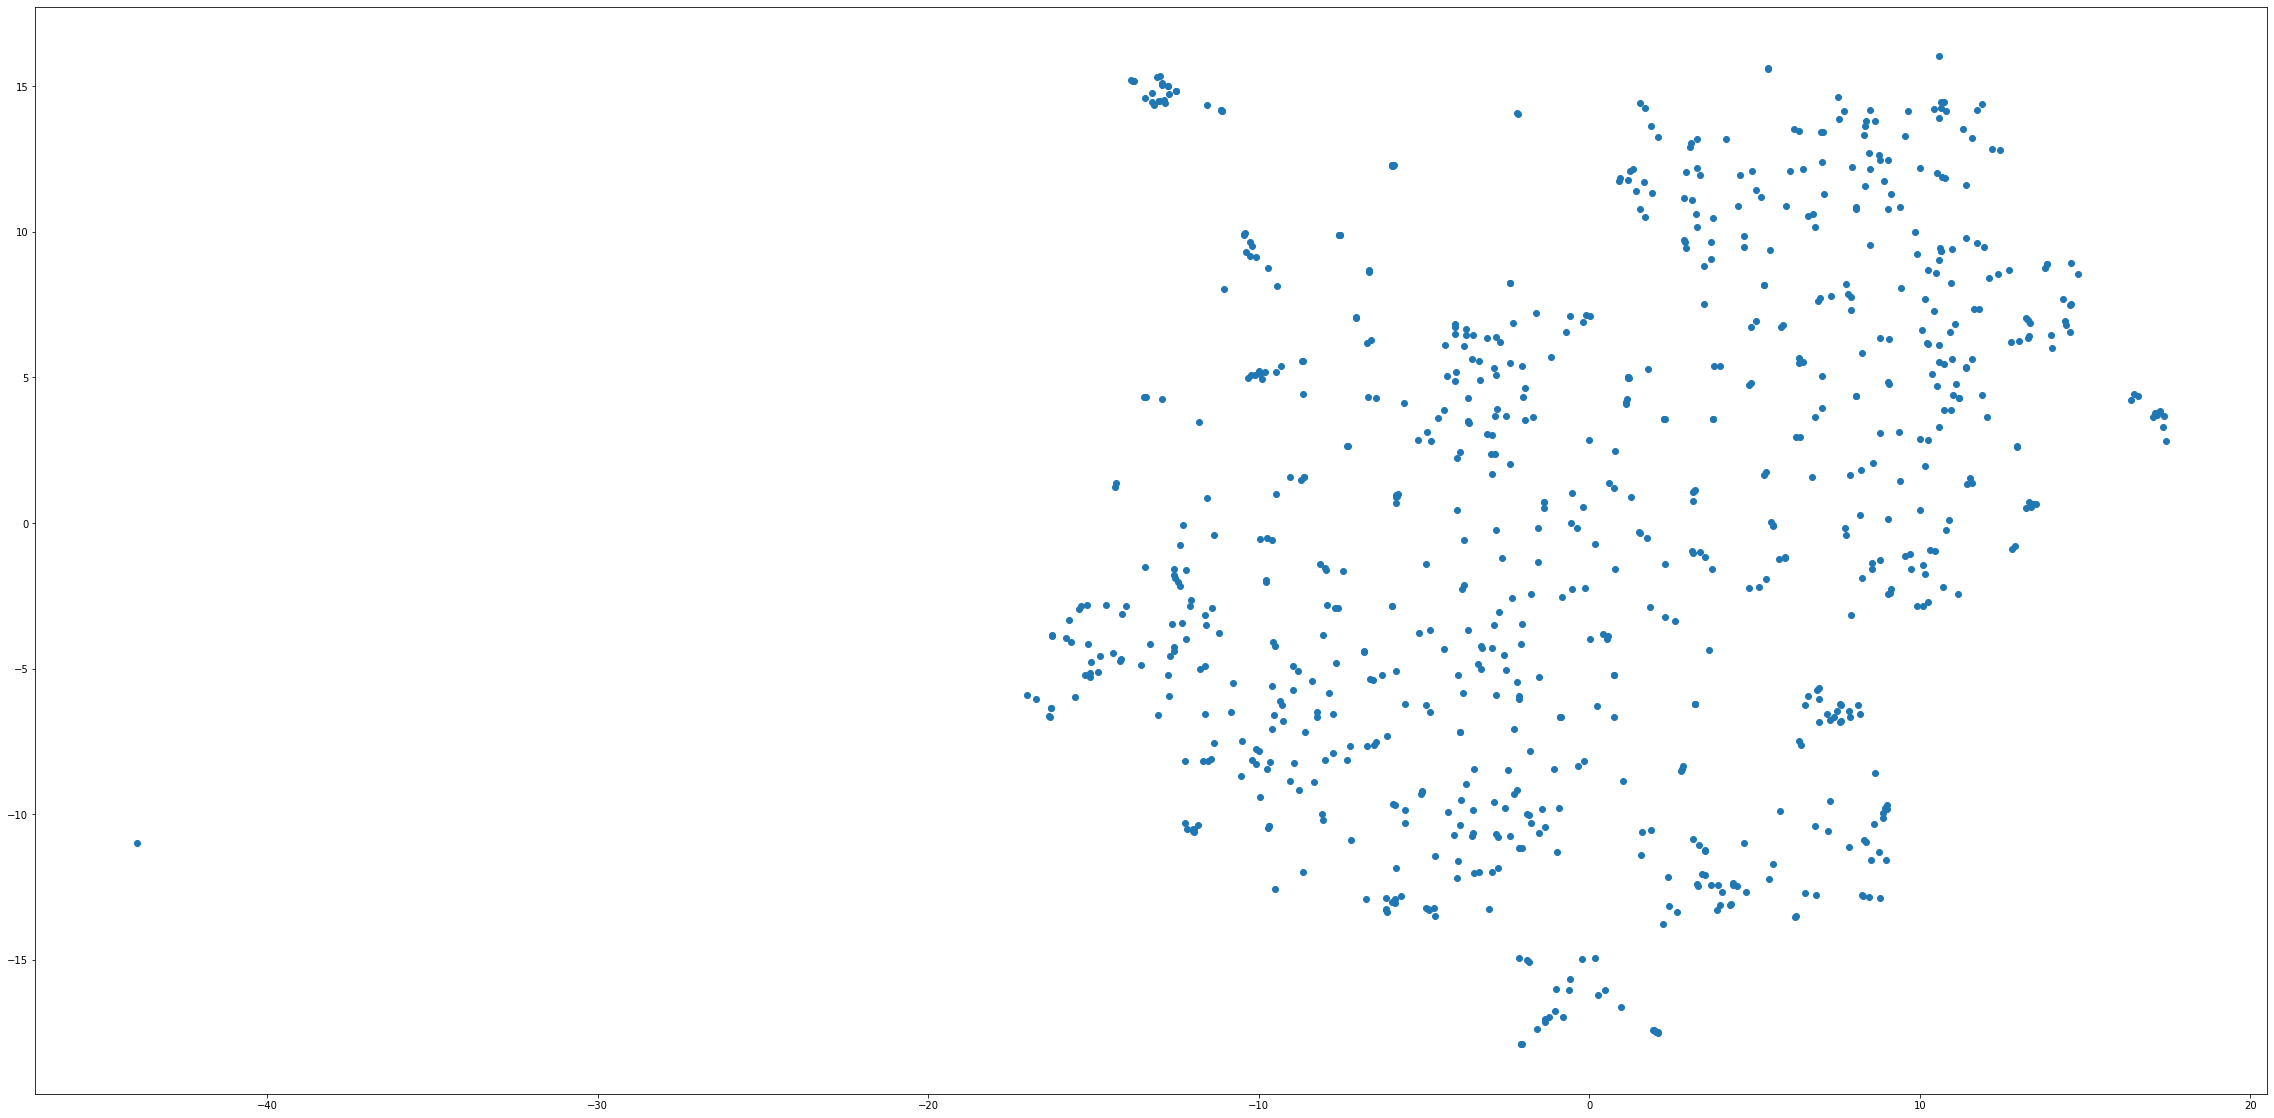

In [21]:
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_df["x"], tsne_df["y"])

#for word, pos in list(df.iterrows()):
#    ax.annotate(word, pos, fontsize=12, fontproperties=prop)
plt.show()

## 군집개수 결정 - 엘보우 함수

엘보우: 100%|██████████| 14/14 [00:01<00:00,  7.26it/s]


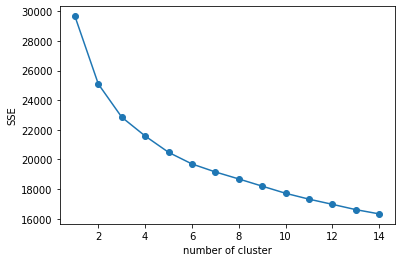

In [22]:
# 엘보우 함수로 군집 개수 결정

word_vectors = gender['문장벡터'].to_list() # 함수에 넣을 X값 지정
elbow(word_vectors)

## 군집개수 결정 - 실루엣 계수

In [23]:
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from matplotlib import cm

def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    plt.axvline(silhoutte_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('K')
    plt.xlabel('silhouette')
    plt.show()

## KMeans

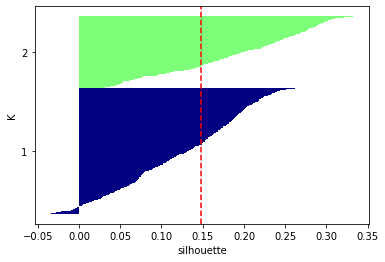

In [24]:
word_vectors = gender['문장벡터'].to_list()
k= 2

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

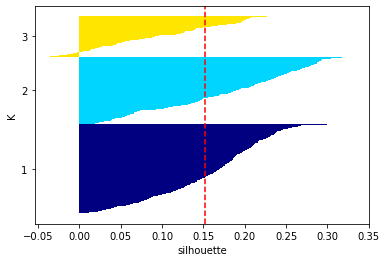

In [25]:
word_vectors = gender['문장벡터'].to_list()
k= 3

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

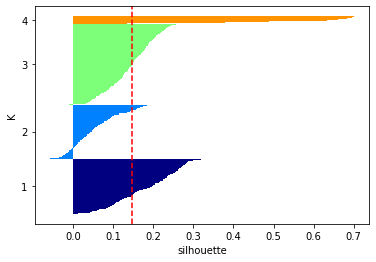

In [26]:
word_vectors = gender['문장벡터'].to_list()
k= 4

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

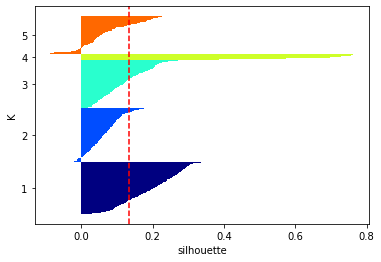

In [27]:
word_vectors = gender['문장벡터'].to_list()
k= 5

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

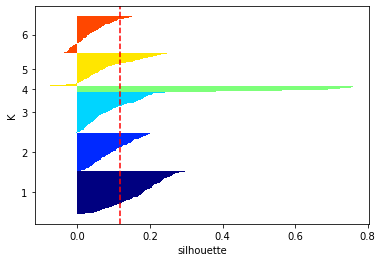

In [28]:
word_vectors = gender['문장벡터'].to_list()
k= 6

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

## KMeans 수행

In [29]:
# K means 수행 
word_vectors = gender['문장벡터'].to_list()
num_clusters = 4

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)
gender['category'] = idx

In [30]:
gender['category'].value_counts()

3    324
1    244
2    219
0     31
Name: category, dtype: int64

In [31]:
from sklearn.manifold import TSNE

X = gender['문장벡터'].to_list()
y = gender['category'].to_list()

import os.path
import pickle

tsne_filepath = 'tsne3000.pkl'

tsne = TSNE(random_state=42)
tsne_points = tsne.fit_transform(X)

'''
# File Cache
if not os.path.exists(tsne_filepath):
    tsne = TSNE(random_state=42)
    tsne_points = tsne.fit_transform(X)
    with open(tsne_filepath, 'wb+') as f:
        pickle.dump(tsne_points, f)
else: # Cache Hits!
    with open(tsne_filepath, 'rb') as f:
        tsne_points = pickle.load(f)
'''

tsne_df = pd.DataFrame(tsne_points, index=range(len(X)), columns=['x_coord', 'y_coord'])
tsne_df['BillNo'] = gender['의안번호'].to_list()
tsne_df['BillName'] = gender['의안명'].to_list()
tsne_df['cluster_no'] = y

In [32]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.palettes import brewer

output_notebook()

Loading BokehJS ...

In [33]:
# 색 정해주기

colors = brewer["Spectral"][len(tsne_df['cluster_no'].unique())]
colormap = {i: colors[i] for i in tsne_df['cluster_no'].unique()}
colors = [colormap[x] for x in tsne_df['cluster_no']]
tsne_df['color'] = colors

In [34]:
# Bokeh가 인식하는 DataSource 객체 만들어주기
plot_data = ColumnDataSource(
    data=tsne_df.to_dict(orient='list')
)

# Plot 만들기(배경)
tsne_plot = figure(
    title='Bills about gender',
    plot_width = 650,
    plot_height = 650,
    active_scroll='wheel_zoom',
    output_backend="webgl", # GPU 가속
)

In [35]:
# 마우스 올렸을 때 보여줄 것

tsne_plot.add_tools(
    HoverTool(
        tooltips= '@BillName'
    )
)

# 데이터 정보 넣기

tsne_plot.circle(
    source=plot_data,
    x='x_coord',
    y='y_coord',
    line_alpha=0.3, 
    fill_alpha=0.2,
    size=10,
    fill_color='color',
    line_color='color',
)

# 선 지우기

tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None


show(tsne_plot)


## 군집별 핵심단어 추출

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


2020-09-27 00:43:00,049 : INFO : Generating new fontManager, this may take some time...
2020-09-27 00:43:00,878 : INFO : Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (error code 0x17)
2020-09-27 00:43:01,572 : INFO : Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str
2020-09-27 00:43:02,003 : INFO : Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (error code 0x17)


In [37]:
gender_g1 = gender[gender['category'] == 0]
gender_g2 = gender[gender['category'] == 1]
gender_g3 = gender[gender['category'] == 2]
gender_g4 = gender[gender['category'] == 3]
# gender_g5 = gender[gender['category'] == 4]
# gender_g6 = gender[gender['category'] == 5]
# gender_g7 = gender[gender['category'] == 6]

In [38]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
            
gender_g1_tokens = total_tokens(gender_g1['tokens'])
gender_g2_tokens = total_tokens(gender_g2['tokens'])
gender_g3_tokens = total_tokens(gender_g3['tokens'])
gender_g4_tokens = total_tokens(gender_g4['tokens'])
# gender_g5_tokens = total_tokens(gender_g5['tokens'])
# gender_g6_tokens = total_tokens(gender_g6['tokens'])

In [39]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고', '대안','대표발의','국회','신설','법률안','임시회','의결','규정','항제',
            '제공','결과','현행','회부']
gender_g1_tokens = [each_word for each_word in gender_g1_tokens if each_word not in stopwords]
gender_g2_tokens = [each_word for each_word in gender_g2_tokens if each_word not in stopwords]
gender_g3_tokens = [each_word for each_word in gender_g3_tokens if each_word not in stopwords]
gender_g4_tokens = [each_word for each_word in gender_g4_tokens if each_word not in stopwords]
# gender_g5_tokens = [each_word for each_word in gender_g5_tokens if each_word not in stopwords]
# gender_g6_tokens = [each_word for each_word in gender_g6_tokens if each_word not in stopwords]

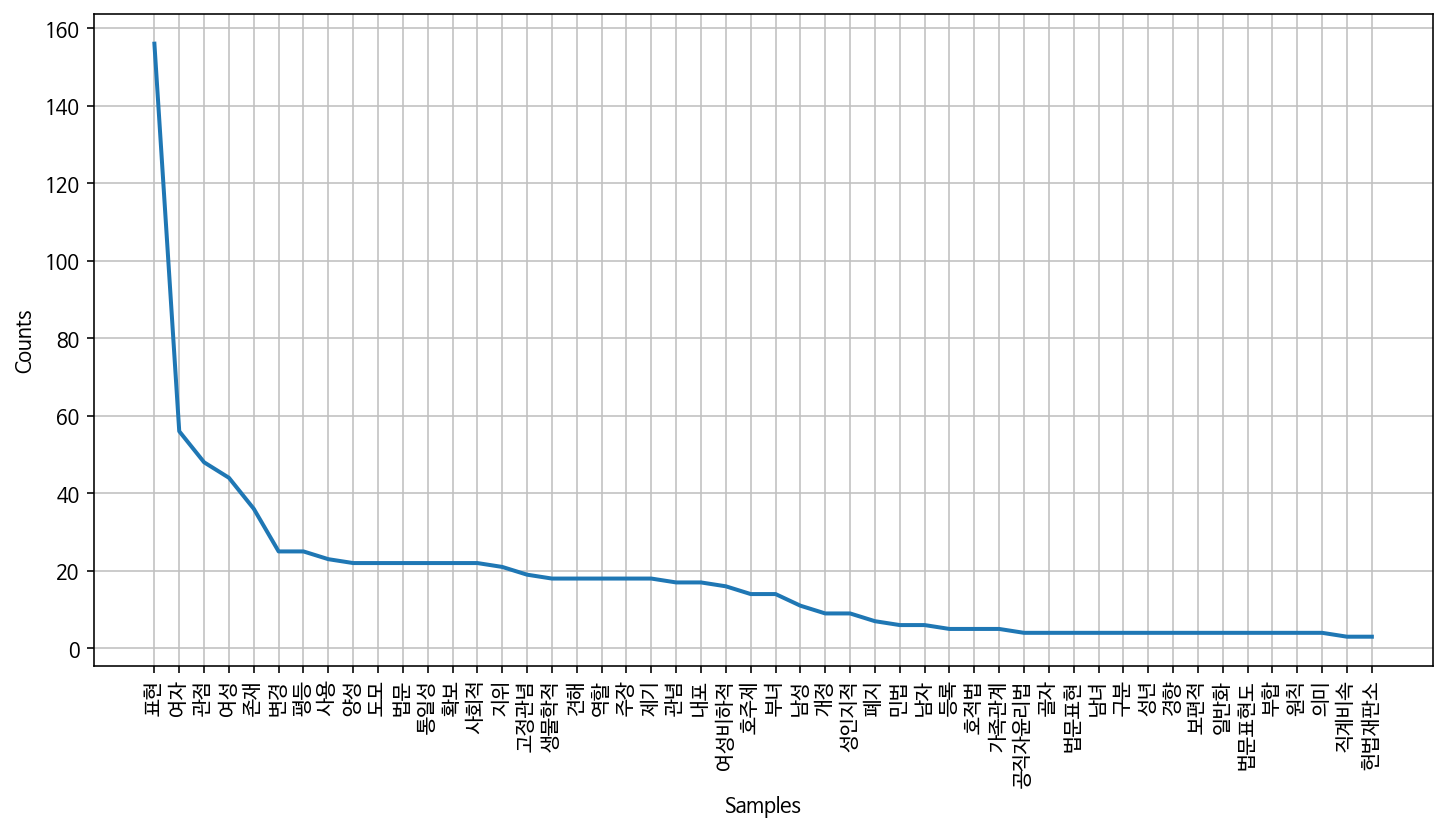

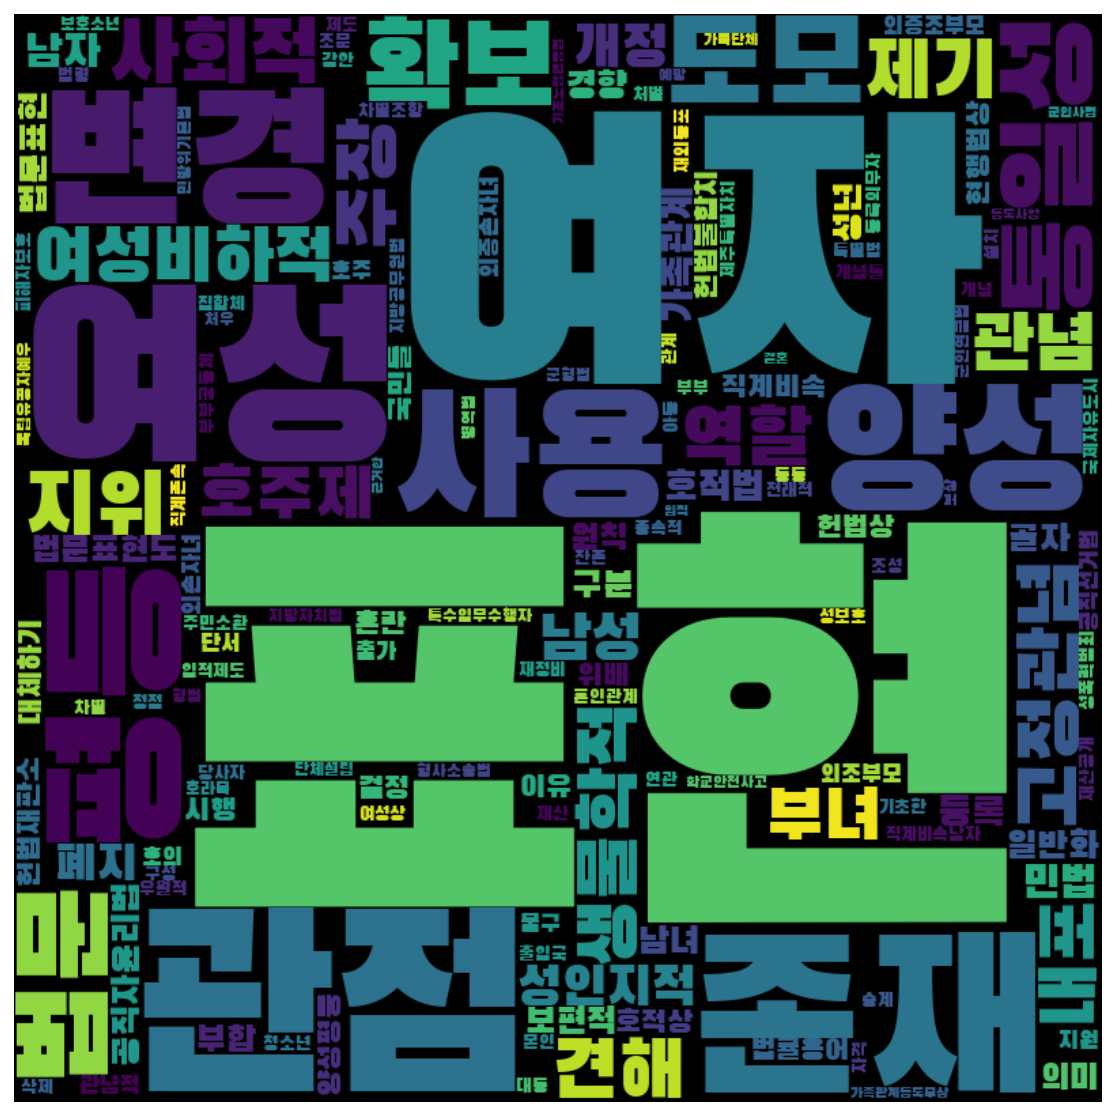

In [40]:
frewords_vis(gender_g1_tokens)
wordcloud_vis(gender_g1_tokens)

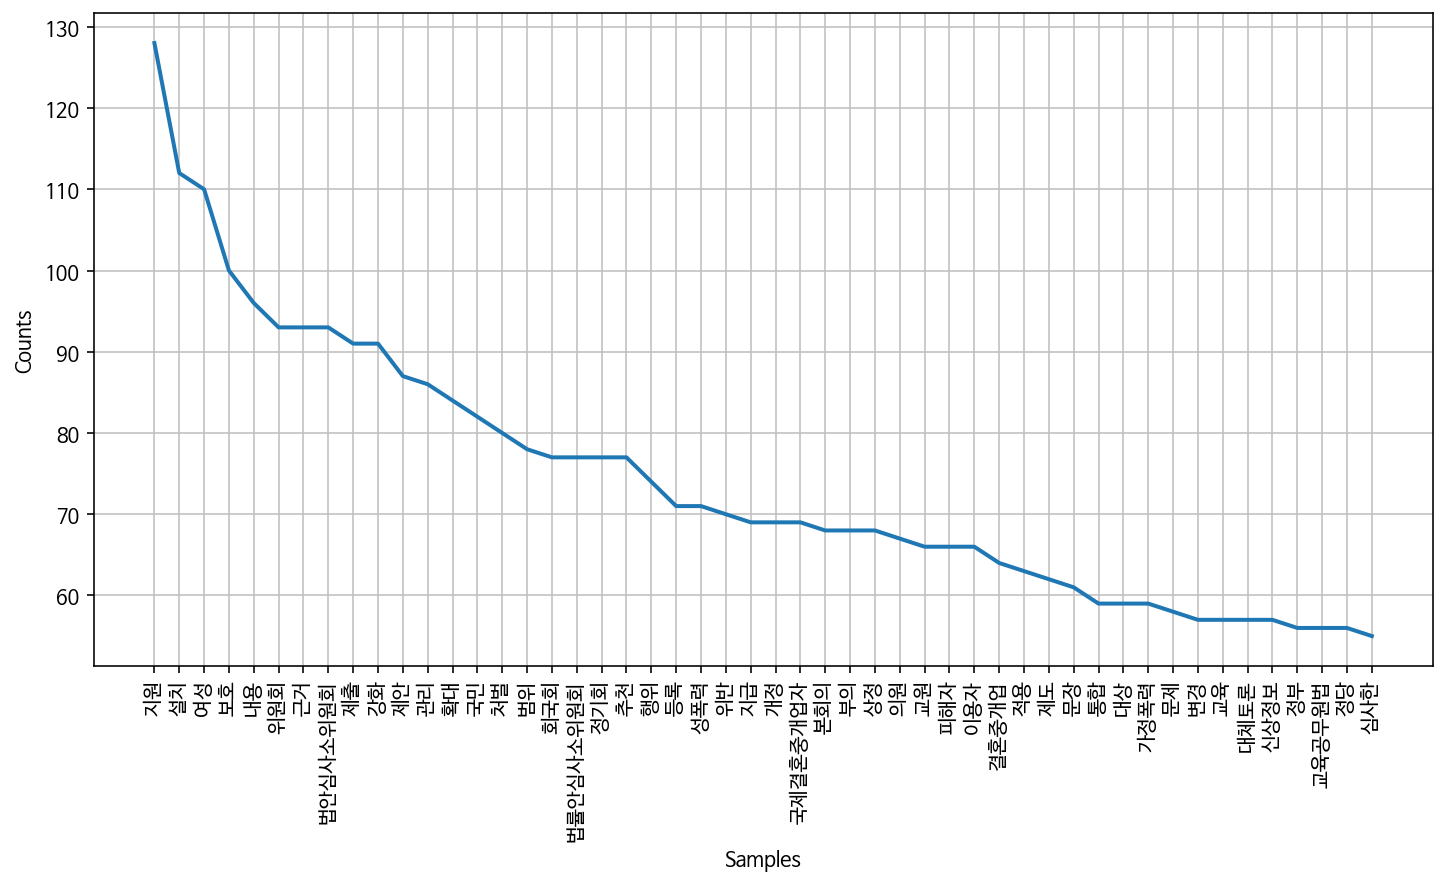

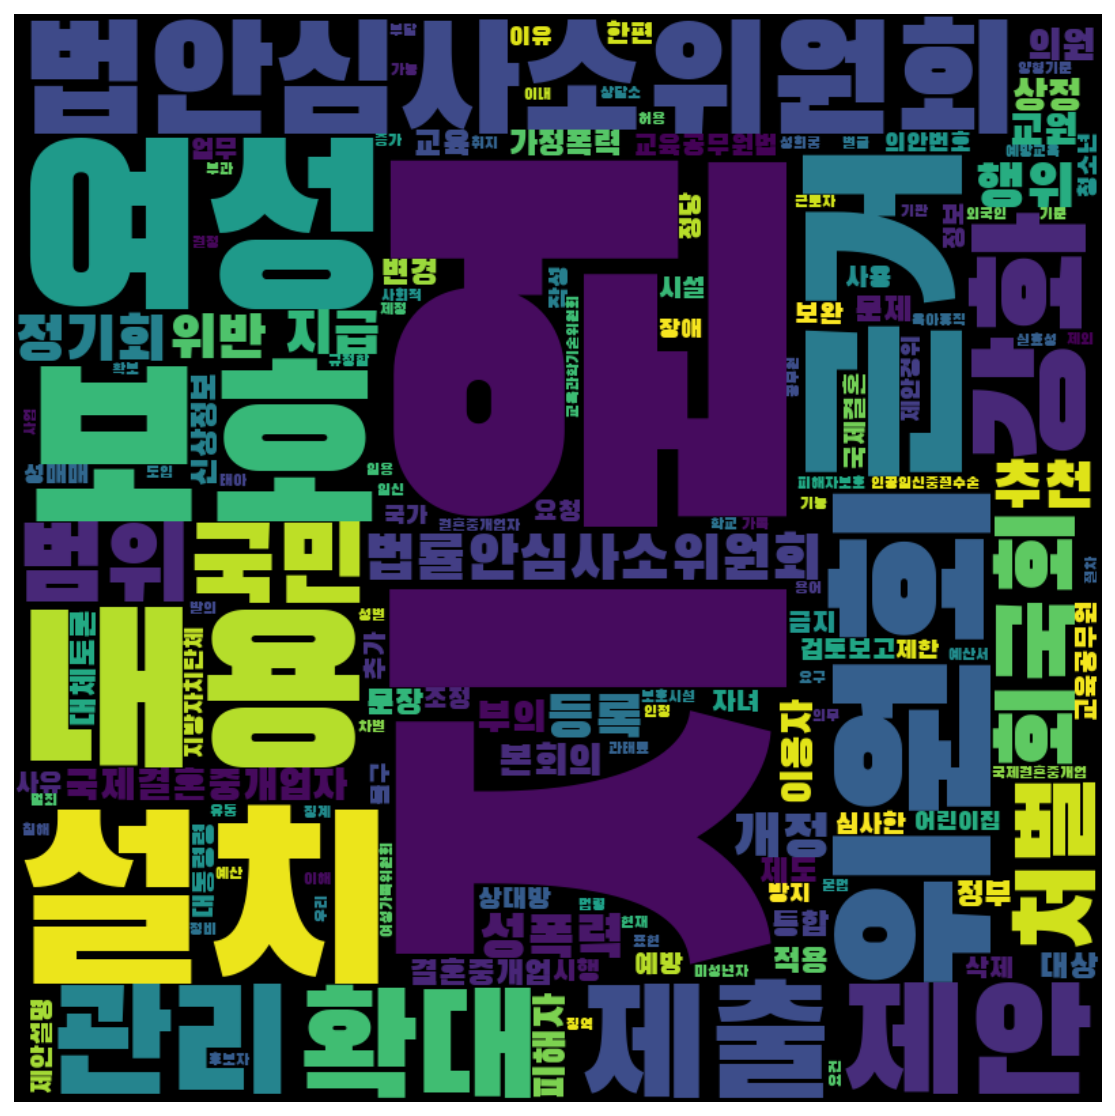

In [41]:
frewords_vis(gender_g2_tokens)
wordcloud_vis(gender_g2_tokens)

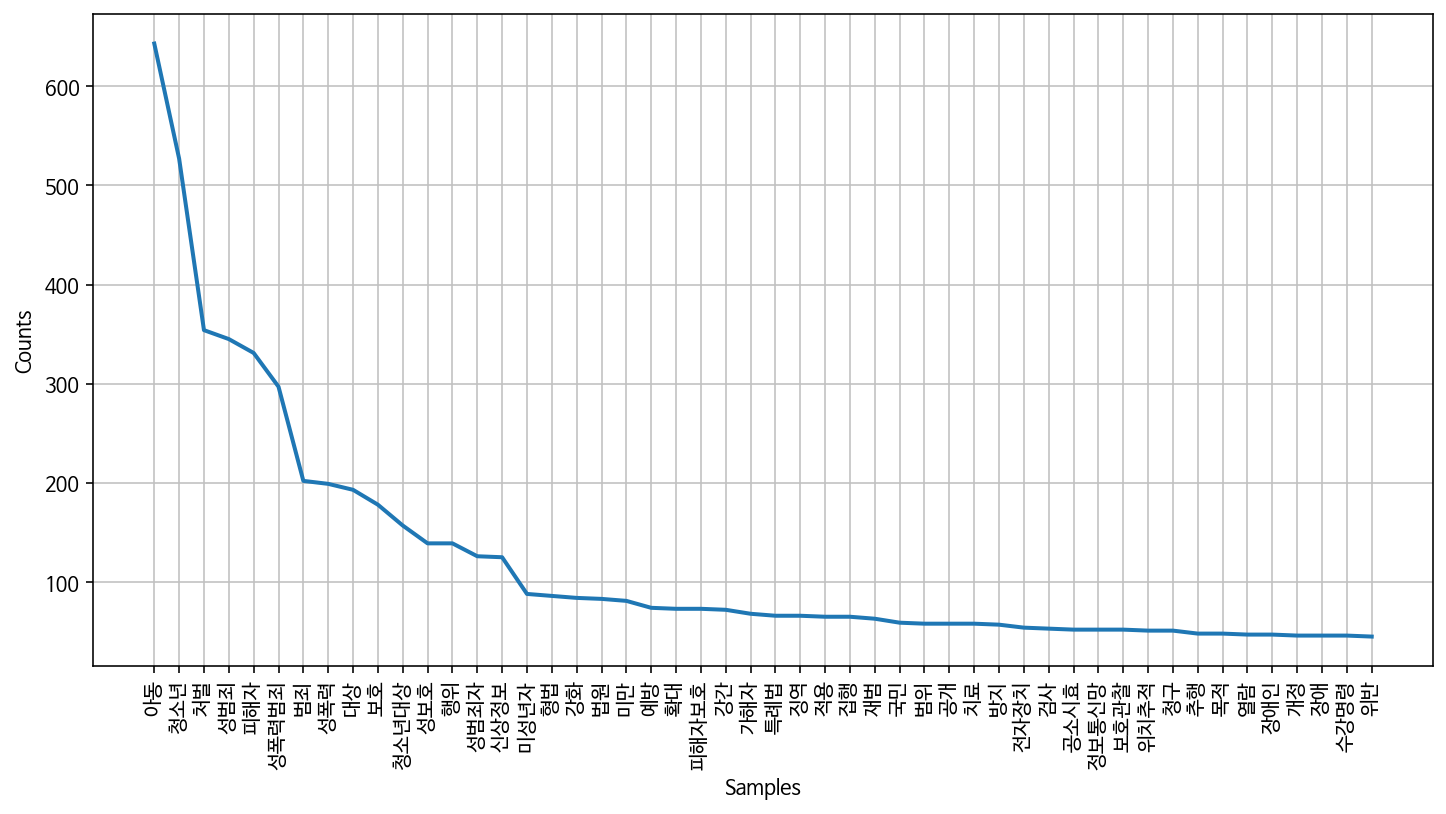

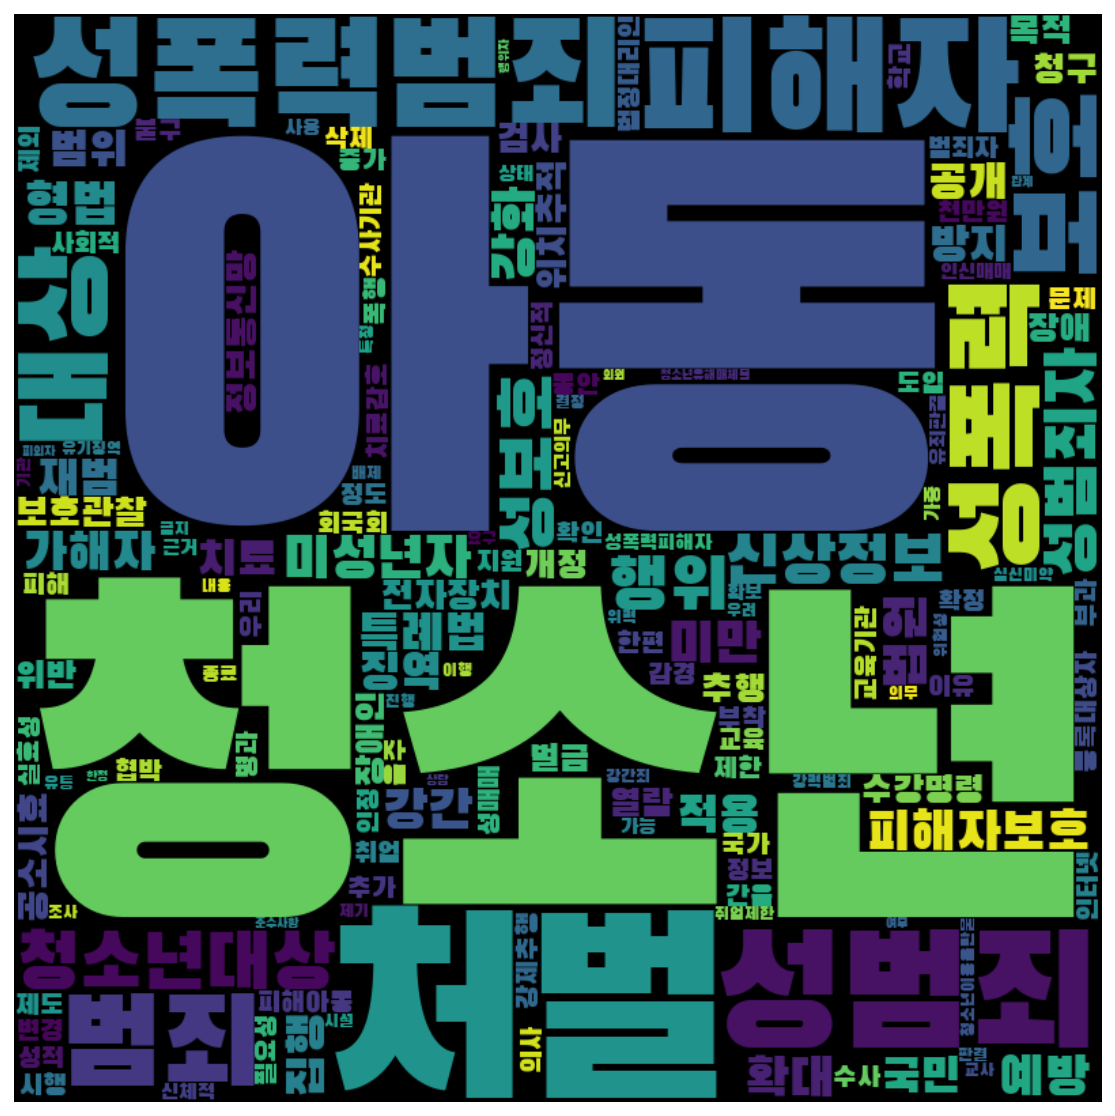

In [42]:
frewords_vis(gender_g3_tokens)
wordcloud_vis(gender_g3_tokens)

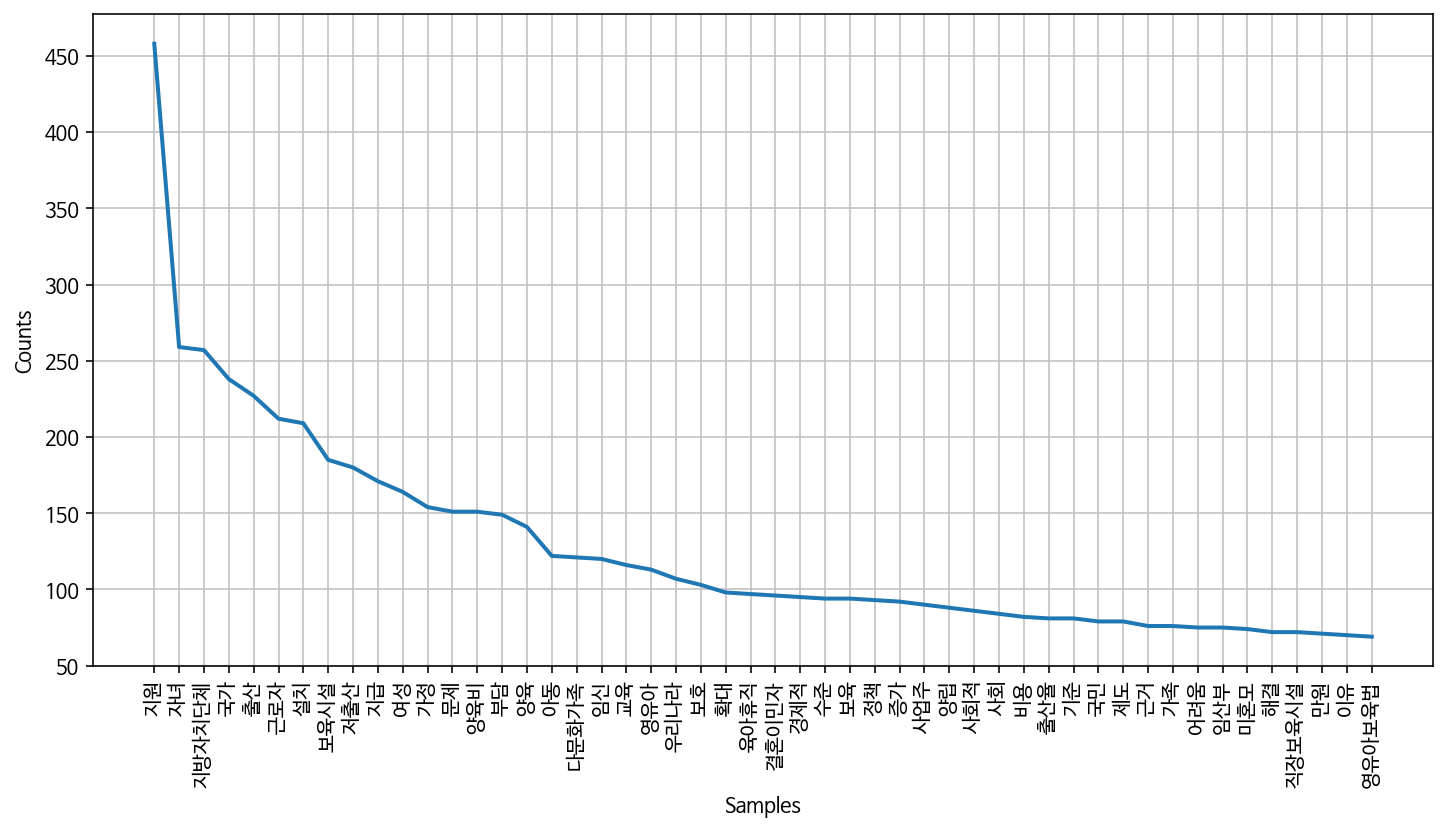

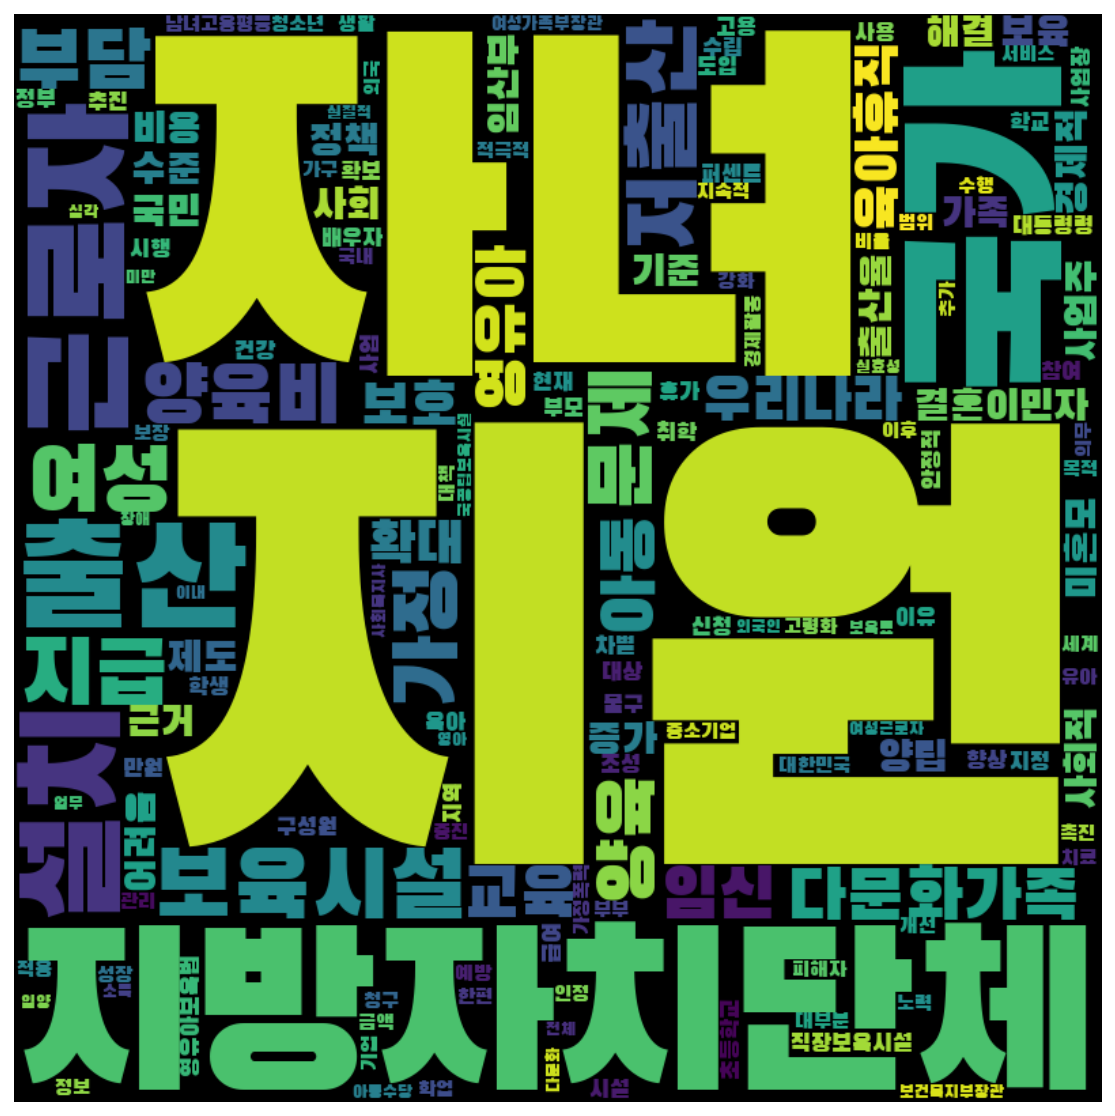

In [43]:
frewords_vis(gender_g4_tokens)
wordcloud_vis(gender_g4_tokens)

In [44]:
# frewords_vis(gender_g5_tokens)
# wordcloud_vis(gender_g5_tokens)

In [45]:
# frewords_vis(gender_g6_tokens)
# wordcloud_vis(gender_g6_tokens)